# Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения.

**Цель проекта:**

Создание рабочей модели способной провести прогнозирование глубины (Depth) и ширины (Width) сварного шва в зависимости от параметров технологического процесса (IW, IF, VW, FP).

**Для выполнения проекта необходимо:**  

1. Посмотреть первичную информацию о данных:
    
    - общая информация о объектах в датасетах
 

2. Провести исследовательский анализ данных:

     - Анализ целевого и основных признаков
     - Поиск аномалий и артефактов в данных
     - Оценить взаимосвязи признаков с друг другом и целевым признаков
     

3. Сделать предобработку данных:

    - Удалить/заменить пустые значения и дубликаты
    - Исправить аномалии в данных
    - Провести кодирование категориальных признаков и масштабирование числовых признаков


4. Построить и обучить модель:

    - Обучить разные модели и оценить их качество c помощью оценки RSME.
    - Замерить и сравнить время обучения и предсказания всех тестируемых моделей
    - Выбрать лучшую модель для данных флотации и финального концентрата, с лучшими итоговыми характеристиками.


5. Выбрать лучшую модель, сделать финальное тестирование на тестовой выборке.

    - Выбраная модель должна затрачивать минимальное время на обучение и предсказание и показать оценку RSME менее 2500.

## Подготовка данных

### Импорт библиотек, настройки и константы

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor


from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNetCV
from lightgbm import LGBMRegressor

from IPython.display import display
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.precision', 3)
np.set_printoptions(precision=3, suppress=True)

In [5]:
#константы 
STATE = np.random.RandomState(13)

### Загрузка данных

In [8]:
data = pd.read_csv('ebw_data.csv')
display(data.head())

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


### Изучение и предобработка данных

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


Датасет содержит 72 объекта, 6 колонок (признаков):

из 4 основных признаков:
- IW - Снижение величины сварочного тока;
- IF - Увеличение тока фокусировки электронного пучка;
- VW - Увеличение скорости сварки;
- FP - Изменение расстояния от поверхности образцов до электронно-оптической системы. 

и 2 целевых признаков:

- Depth - Глубина шва
- Width - Ширина шва

В дата сете нет пустых значений, наименование столбцов не соотвествуют стандартам `snake_case`.
В датафрейме все признаки непрерывные.  


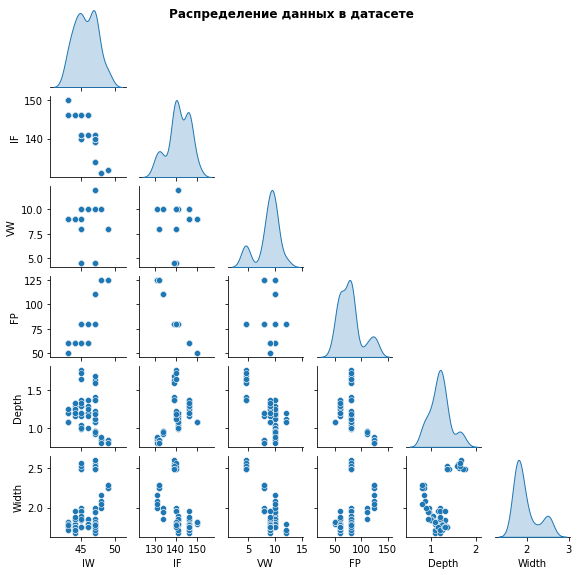

In [10]:
sns.pairplot(data, height=1.35, diag_kind='kde', corner=True)
plt.suptitle(f'Распределение данных в датасете', fontweight="bold")
plt.show()

Отметим зависимость между признаками IF и IW, IF и FP, FP и IW,  а так же достаточно сильную взаимосвязь между целевыми признаками и VW.

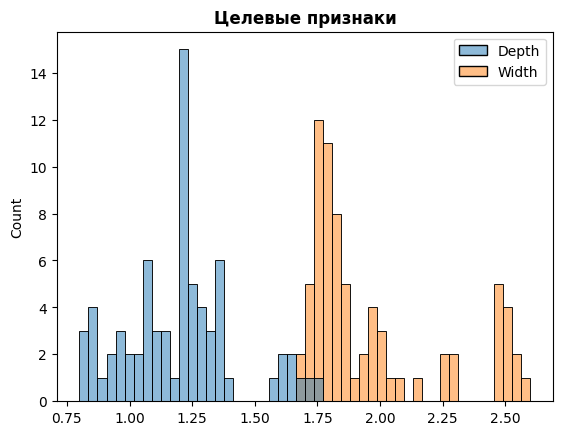

In [11]:
sns.histplot(data[data.columns[-2:]], bins=50);
plt.title(f'Целевые признаки', fontweight="bold")
plt.show()

По имеющимся данным сложно сделать вывод по распределению целевых признаков на гистограмме.

## Переименуем название признаков в соотвествии со стандартами `snake_case`

In [15]:
#Создадим копию базы, чтоб сохранить оригинал
df = data.copy()
#переименуем столбцы
df.columns = df.columns.map(lambda x: x.lower())
display(df.tail(2))

,iw,if,vw,fp,depth,width
70,45,146,9.0,60,1.28,1.76
71,45,146,9.0,60,1.32,1.76


In [16]:
display(f'Количество полных дубликатов - {df.duplicated().sum()}')

'Количество полных дубликатов - 7'

В датасете есть дубликаты, но т.к. в данных больше нет сведений, которые говорят про уникальность записи (например, время размещения объявления) - будем считать эти дубликаты разными попытками, но с одинаковыми данными и оставим в датасете.

Посмотрим уникальные значения во входных признаках.

In [17]:
for col in df.columns[:-2]:
    print('Уникальные значения {}:'.format(col))
    display(df[col].value_counts().to_frame(name=col).T)
    print()

Уникальные значения iw:


,47,45,44,46,43,48,49
iw,20,16,12,8,8,4,4



Уникальные значения if:


,146,140,141,139,134,131,132,150
if,24,12,12,8,4,4,4,4



Уникальные значения vw:


,10.0,9.0,4.5,8.0,12.0
vw,24,24,12,8,4



Уникальные значения fp:


,80,60,125,110,50
fp,32,24,8,4,4


#### Поиск и удаление аномалий

In [18]:
#Для построения графиков для анализа и расчета основных стат показателей
def analysis_plots(df, column):
    fig, ax = plt.subplots(figsize=(17,10))
   
    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x=column, kde=True, bins=50)
    plt.title('Histogram')
  
    plt.subplot(2, 2, 2)
    stats.probplot(df[column], dist="norm", plot=plt)
   
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[column])    
    plt.title('Violin plot')
    
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[column])  
    fig.suptitle(f'Диагностика признака - {column}', fontweight='bold', fontsize = 12)
    plt.title('Box plot')
    plt.show()
    
    print(f'Уникальные значения "{column}":')
    display(df[column].value_counts().to_frame().sort_index().T)
    print()
    print('Статистические показатели:')
    display(pd.DataFrame([{'5_quantile' : df[column].quantile(0.05),
                          '95_quantile' : df[column].quantile(0.95),
                          'min' : df[column].min(),
                          'median' : df[column].median(),
                          'max' : df[column].max()
                         }], index=[column]))

In [19]:
display(df.describe())

,iw,if,vw,fp,depth,width
count,72.000,72.000,72.000,72.000,72.000,72.000
mean,45.667,141.333,8.639,78.333,1.196,1.970
std,1.678,5.146,2.061,21.494,0.225,0.279
min,43.000,131.000,4.500,50.000,0.800,1.680
25%,44.000,139.000,8.000,60.000,1.080,1.760
50%,45.500,141.000,9.000,80.000,1.200,1.840
75%,47.000,146.000,10.000,80.000,1.290,2.050
max,49.000,150.000,12.000,125.000,1.760,2.600


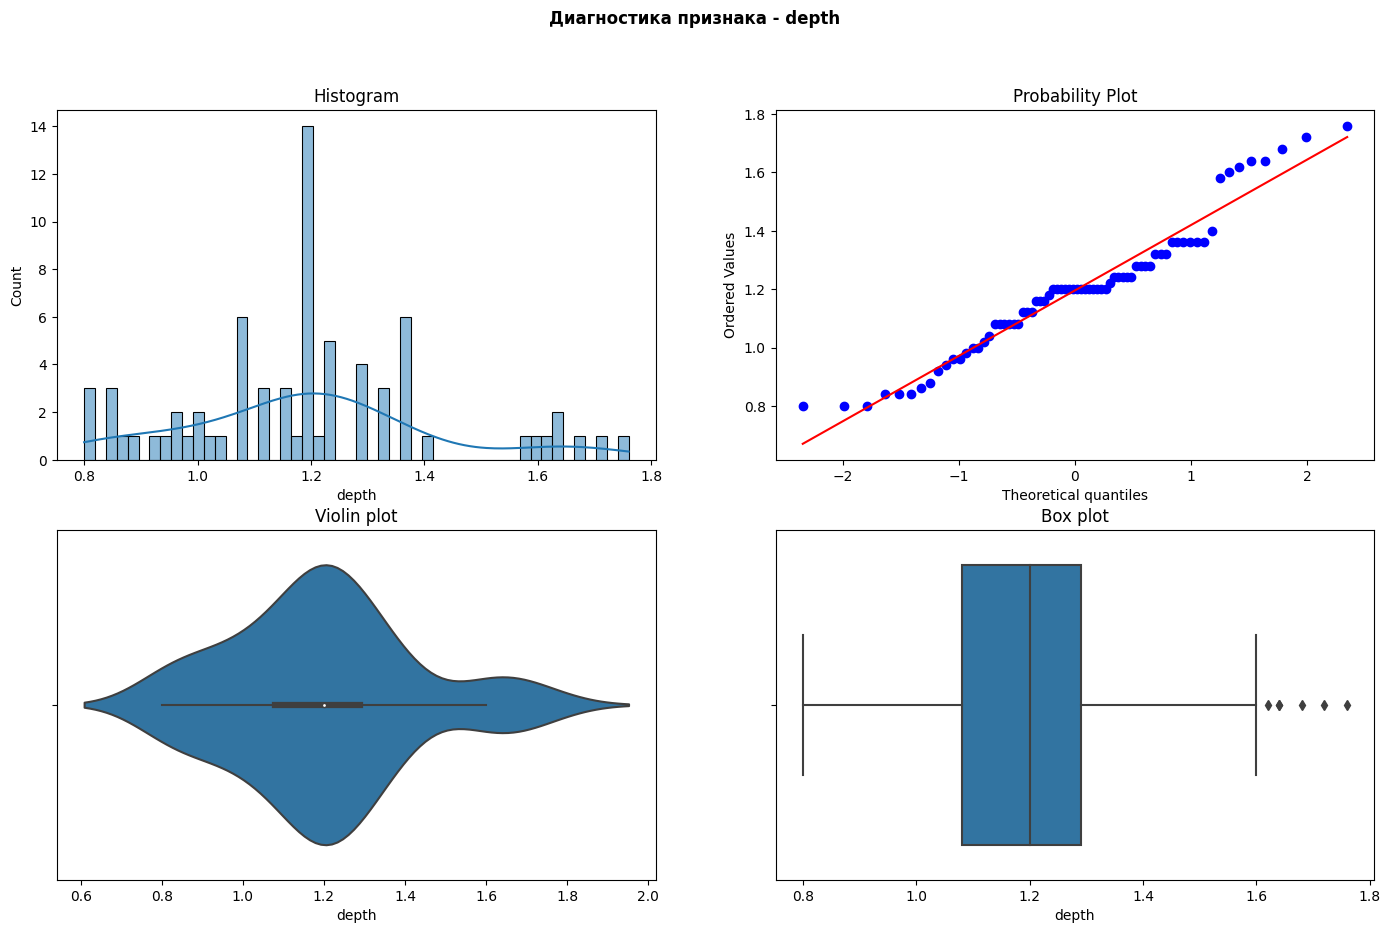

Уникальные значения "depth":


,0.80,0.84,0.86,0.88,0.92,0.94,0.96,0.98,1.00,1.02,1.04,1.08,1.12,1.16,1.18,1.20,1.22,1.24,1.28,1.32,1.36,1.40,1.58,1.60,1.62,1.64,1.68,1.72,1.76
depth,3,3,1,1,1,1,2,1,2,1,1,6,3,3,1,14,1,5,4,3,6,1,1,1,1,2,1,1,1



Статистические показатели:


,5_quantile,95_quantile,min,median,max
depth,0.84,1.64,0.8,1.2,1.76


In [20]:
analysis_plots(df, 'depth')

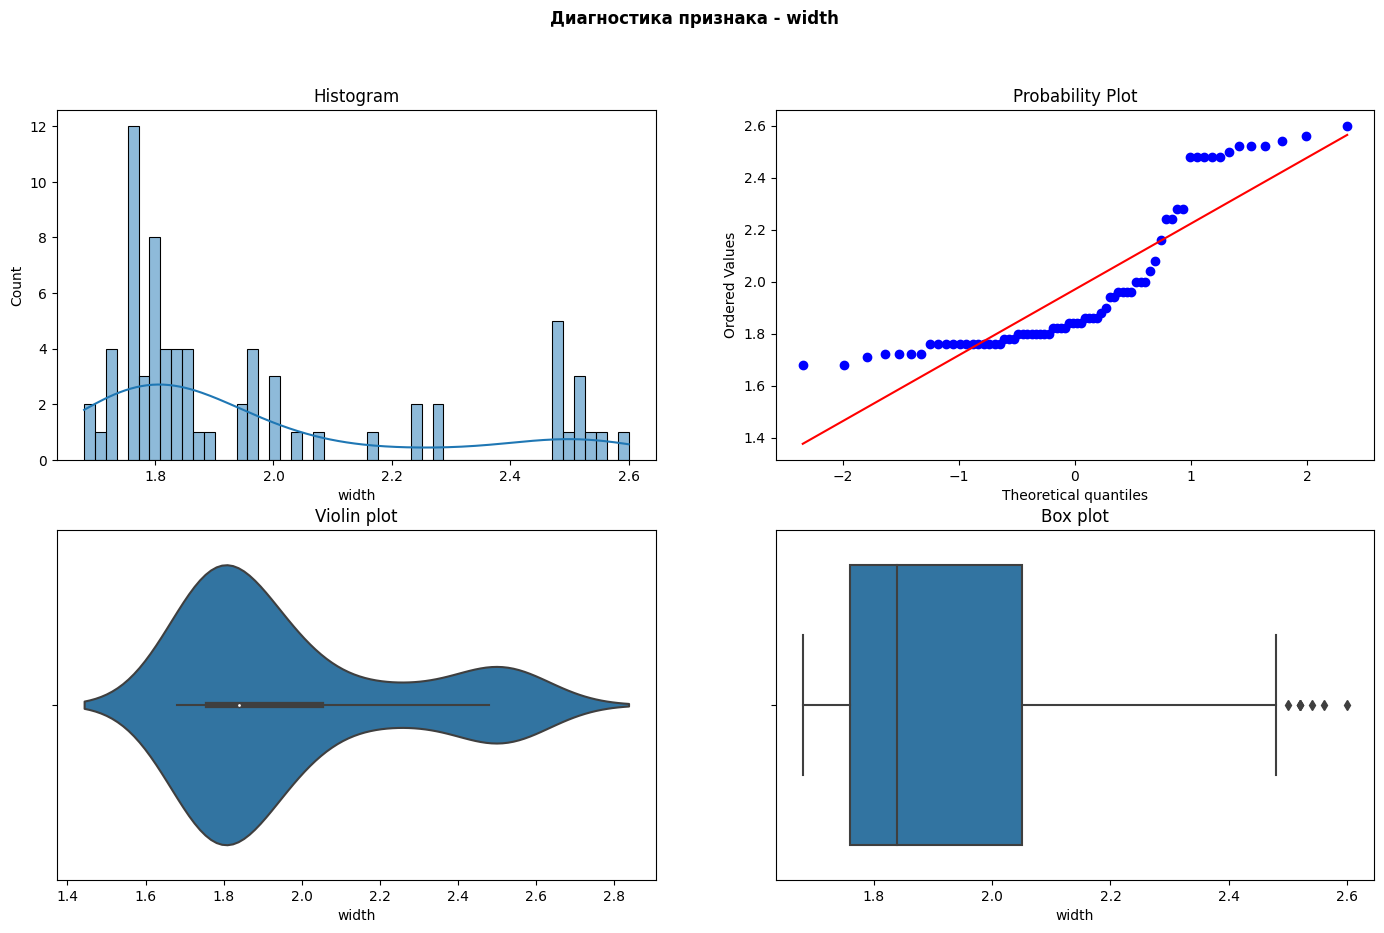

Уникальные значения "width":


,1.68,1.71,1.72,1.76,1.78,1.80,1.82,1.84,1.86,1.88,1.90,1.94,1.96,2.00,2.04,2.08,2.16,2.24,2.28,2.48,2.50,2.52,2.54,2.56,2.60
width,2,1,4,12,3,8,4,4,4,1,1,2,4,3,1,1,1,2,2,5,1,3,1,1,1



Статистические показатели:


,5_quantile,95_quantile,min,median,max
width,1.72,2.52,1.68,1.84,2.6


In [21]:
analysis_plots(df, 'width')

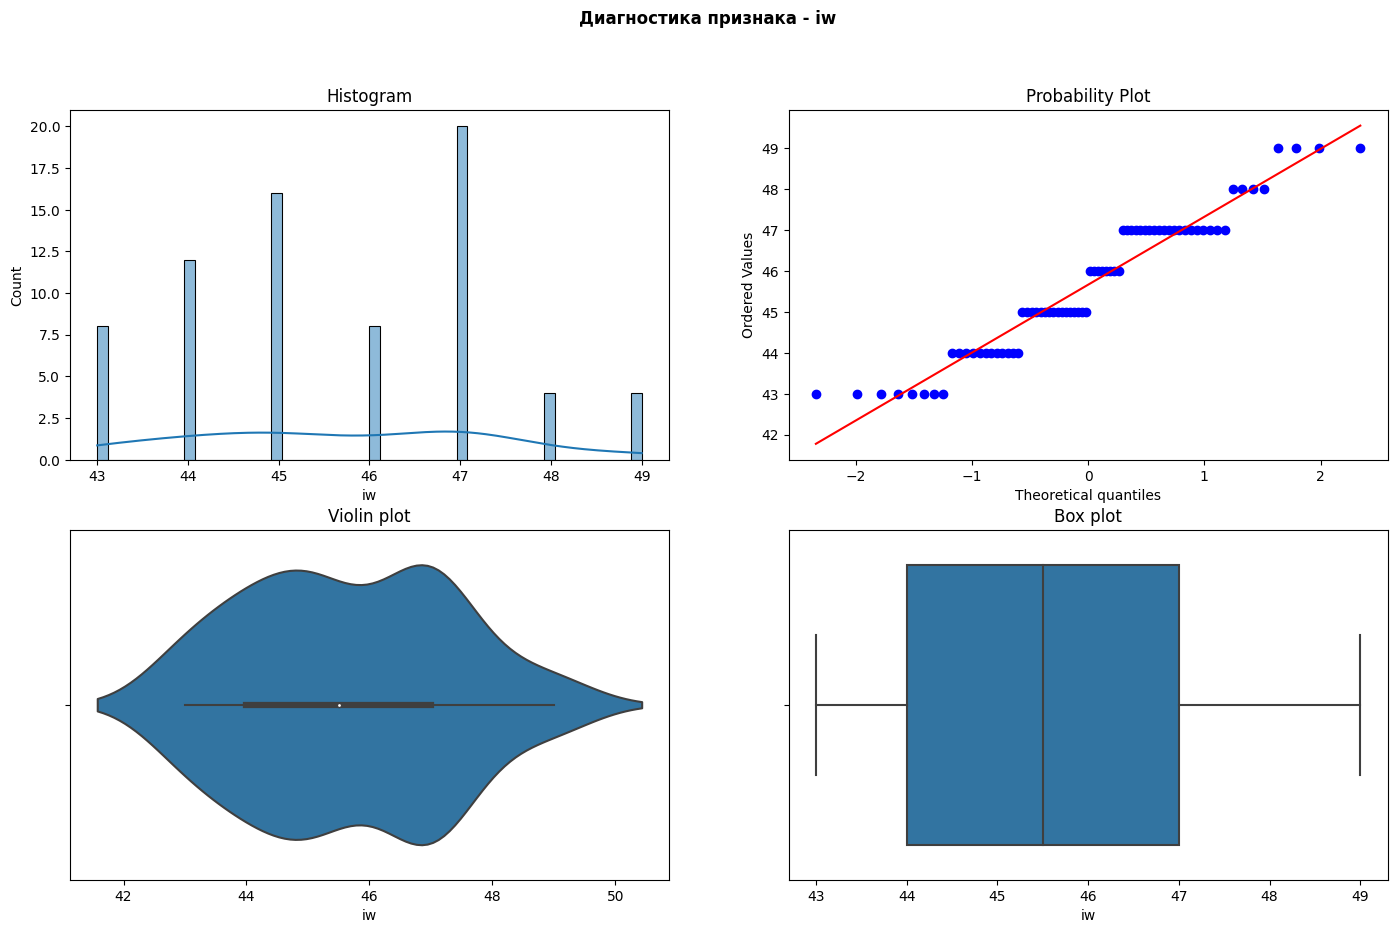

Уникальные значения "iw":


,43,44,45,46,47,48,49
iw,8,12,16,8,20,4,4



Статистические показатели:


,5_quantile,95_quantile,min,median,max
iw,43.0,48.45,43,45.5,49


In [22]:
analysis_plots(df, 'iw')

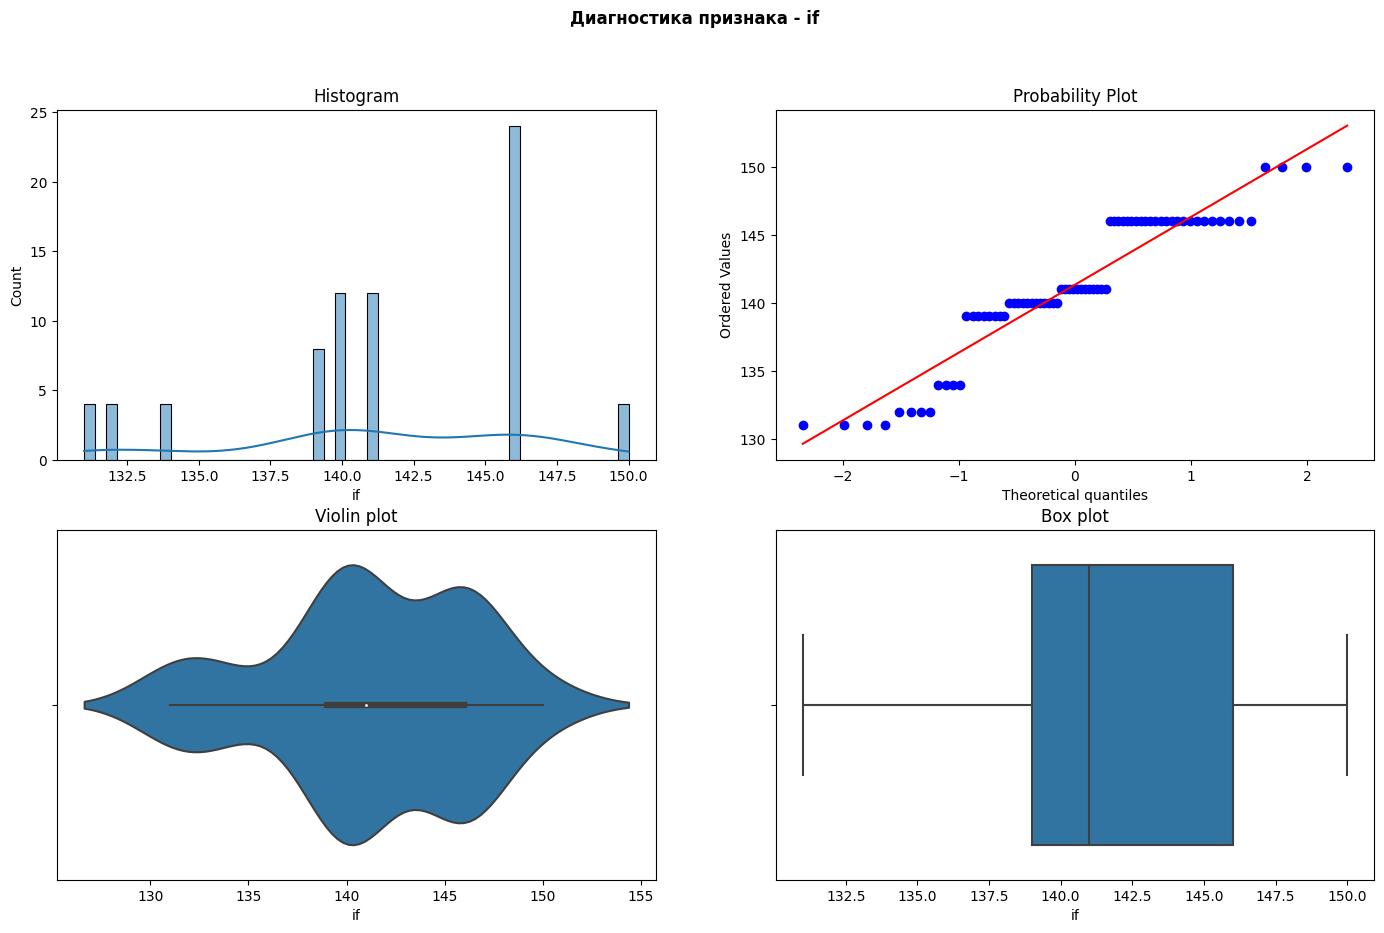

Уникальные значения "if":


,131,132,134,139,140,141,146,150
if,4,4,4,8,12,12,24,4



Статистические показатели:


,5_quantile,95_quantile,min,median,max
if,131.55,147.8,131,141.0,150


In [23]:
analysis_plots(df, 'if')

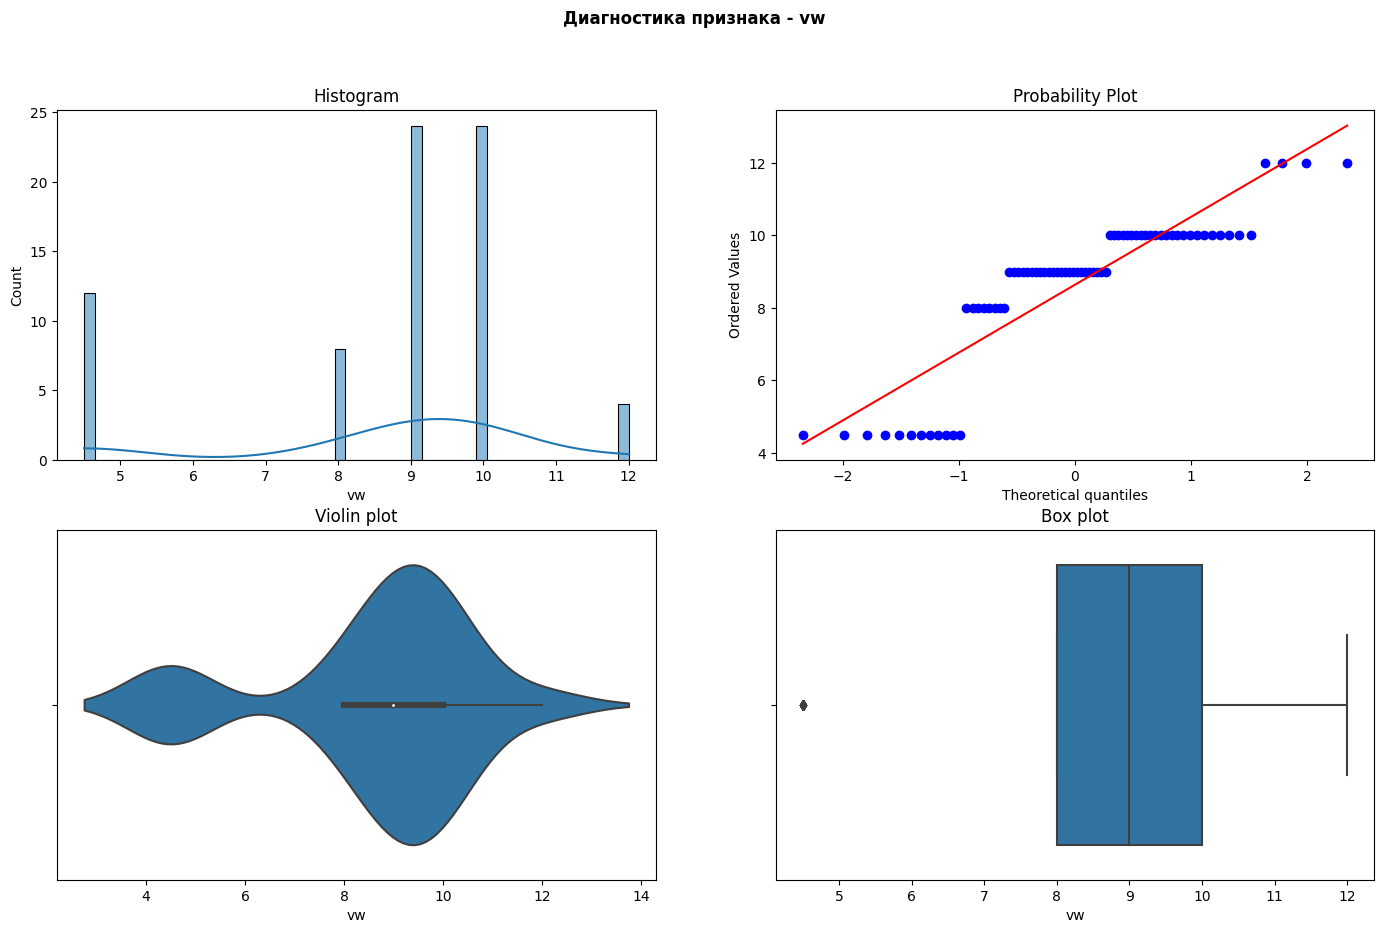

Уникальные значения "vw":


,4.5,8.0,9.0,10.0,12.0
vw,12,8,24,24,4



Статистические показатели:


,5_quantile,95_quantile,min,median,max
vw,4.5,10.9,4.5,9.0,12.0


In [24]:
analysis_plots(df, 'vw')

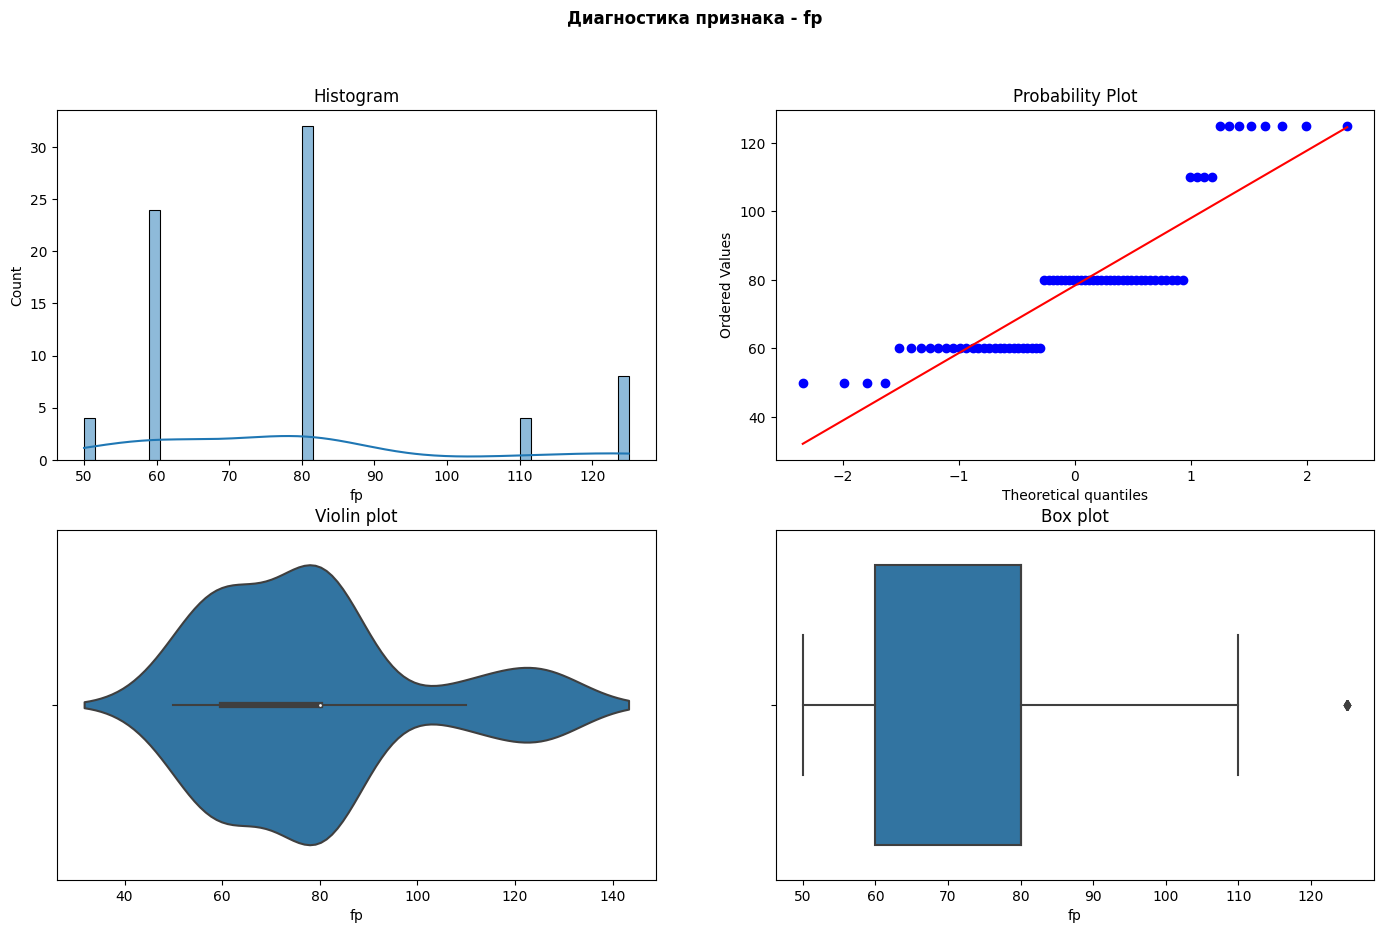

Уникальные значения "fp":


,50,60,80,110,125
fp,4,24,32,4,8



Статистические показатели:


,5_quantile,95_quantile,min,median,max
fp,55.5,125.0,50,80.0,125


In [25]:
analysis_plots(df, 'fp')

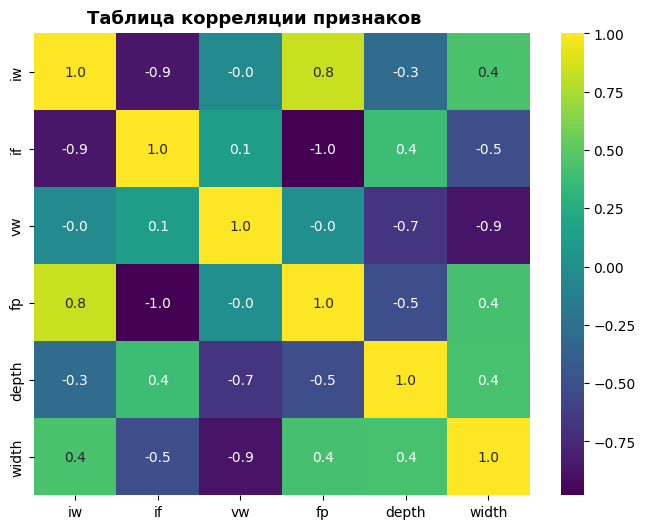

In [26]:
plt.figure(figsize = (8, 6))
sns.heatmap(
    data=df.corr(), 
    annot=True, fmt='0.1f', cmap='viridis')
plt.suptitle(f'Таблица корреляции признаков', 
             fontweight='bold',
             fontsize = 13,
             y = 0.92, x=0.4)
plt.show()

По имеющимся данными и их распределению, учитывая то, что данных мало и наличия информации в открытом доступе можно сделать вывод, все данные влияют на целевые признаки и от их конкретного измерения завият величина и ширины и глубины. Даже несмотря, то что в данных наблюдается мультиколлинеарность, удалять сильно коррелирующие входные признаки между собой в данной выборке не имеет смысла, так как мы потеряем выжную информацию которая определяет ширину и лубину шва. Так же необходимо отметить, что входные признаки имеют строгие метрики в выборке, что может говорить о том, что в данном технологическом процессе есть настройки, в сооветствии с котороыми определяется тот или иной параметр.  

### Подготовим данные для обучение и предсказания

In [27]:
features = df.drop(['depth', 'width'], axis=1)
target = df[['depth', 'width']]

In [28]:
#выделим в тренировочную выборку 15%, т.к. данных мало.
X_train, X_test, y_train, y_test = train_test_split(
    features.values, target.values, test_size=0.15, random_state=STATE)

In [29]:
display(pd.DataFrame(
    {'sample_type':['test_sample', 'train_sample'],
     'target': [y_test.shape[0], 
                y_train.shape[0]],
     'features': [X_test.shape[0],
                  X_train.shape[0]],
     'share': [y_test.shape[0] / features.shape[0], 
               y_train.shape[0] / features.shape[0]]
    }))

,sample_type,target,features,share
0,test_sample,11,11,0.153
1,train_sample,61,61,0.847


### Выберем модели без учета гипперпараметров

Из всех моделей выберемм 3 лучших моделей по наименьшей MAE и далее подберем гипперпараметры для них с использованием `GridSearchCV`

In [30]:
#обучение и предсказие и получение время и оценки
def fit_predict_model(model, feature_train, feature_test, target_train, target_test, predict_only=False):
    if predict_only == False:
        pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
        regr = MultiOutputRegressor(pipe).fit(feature_train, target_train)
        predicts = regr.predict(feature_test)  
        name = model.__class__.__name__
    else:
        predicts = model.predict(feature_test)
        name = model.named_steps.reg.estimator.__class__.__name__
    
    return [name, round(mean_absolute_error(predicts, target_test), 3)]

In [31]:
#хранит оценки моделей 
mae_df = pd.DataFrame(columns=['model', 'mae'])
display(mae_df)

,model,mae


In [32]:
#линейная модель
mae_df.loc[mae_df.shape[0]] = fit_predict_model(LinearRegression(), X_train, X_test, y_train, y_test)
display(mae_df)

,model,mae
0,LinearRegression,0.057


In [33]:
#дерево решений
mae_df.loc[mae_df.shape[0]] = fit_predict_model(DecisionTreeRegressor(random_state=STATE), 
                                                    X_train, X_test, y_train, y_test)
display(mae_df)

,model,mae
0,LinearRegression,0.057
1,DecisionTreeRegressor,0.040


In [34]:
#ближайшие соседи
mae_df.loc[mae_df.shape[0]] = fit_predict_model(KNeighborsRegressor(), X_train, X_test, y_train, y_test)
display(mae_df)

,model,mae
0,LinearRegression,0.057
1,DecisionTreeRegressor,0.040
2,KNeighborsRegressor,0.050


In [35]:
mae_df.loc[mae_df.shape[0]] = fit_predict_model(RandomForestRegressor(random_state=STATE), 
                                                    X_train, X_test, y_train, y_test)
display(mae_df)

,model,mae
0,LinearRegression,0.057
1,DecisionTreeRegressor,0.040
2,KNeighborsRegressor,0.050
3,RandomForestRegressor,0.038


In [36]:
mae_df.loc[mae_df.shape[0]] = fit_predict_model(LGBMRegressor(random_state=STATE), 
                                                    X_train, X_test, y_train, y_test)
display(mae_df)

,model,mae
0,LinearRegression,0.057
1,DecisionTreeRegressor,0.040
2,KNeighborsRegressor,0.050
3,RandomForestRegressor,0.038
4,LGBMRegressor,0.122


In [37]:
mae_df.loc[mae_df.shape[0]] = fit_predict_model(CatBoostRegressor(verbose=0), 
                                                X_train, X_test, y_train, y_test)
display(mae_df)

,model,mae
0,LinearRegression,0.057
1,DecisionTreeRegressor,0.040
2,KNeighborsRegressor,0.050
3,RandomForestRegressor,0.038
4,LGBMRegressor,0.122
5,CatBoostRegressor,0.040


In [38]:
mae_df.loc[mae_df.shape[0]] = fit_predict_model(ElasticNetCV(cv=5, random_state = STATE), 
                                                X_train, X_test, y_train, y_test)
display(mae_df.sort_values('mae'))

,model,mae
3,RandomForestRegressor,0.038
1,DecisionTreeRegressor,0.040
5,CatBoostRegressor,0.040
2,KNeighborsRegressor,0.050
6,ElasticNetCV,0.056
0,LinearRegression,0.057
4,LGBMRegressor,0.122


Лучшие метрики MAE показали модели `RandomForestRegressor`, `DecisionTreeRegressor`, `CatBoostRegressor`, но т.к. `DecisionTreeRegressor` имеют это по сути 1 дерево из случайного леса, заменим его на `KNeighborsRegressor`

### Подбор параметров для 3-х лучших моделей

In [39]:
#функция для получения модели
def find_model(regressor, feature, target, param={}):
    
    pipe = Pipeline([('scaler', StandardScaler()), ('reg', MultiOutputRegressor(regressor))])
    
    clf = GridSearchCV(
        estimator= pipe, 
        param_grid = param, 
        cv = 6, 
        n_jobs=-1,
        scoring= 'neg_mean_absolute_error')    
    
    clf.fit(feature, target)
   
    
    print(f'{regressor.__class__.__name__} train MAE -', -1 * clf.best_score_)
   
    print(clf.best_params_)
   
    return clf.best_estimator_

In [40]:
#обнулим датафрейм
mae_df = mae_df[mae_df.model == 'delete']
mae_df

,model,mae


In [41]:
%%time
cnr_params = {'reg__estimator__n_neighbors': [7,8,9,10], 
           'reg__estimator__weights': ['uniform','distance'],
           'reg__estimator__p':[1,2,5]}
model_cnr = find_model(KNeighborsRegressor(), X_train, y_train, cnr_params)

KNeighborsRegressor train MAE - 0.05456532170186141
{'reg__estimator__n_neighbors': 10, 'reg__estimator__p': 5, 'reg__estimator__weights': 'distance'}
CPU times: user 136 ms, sys: 86.6 ms, total: 223 ms
Wall time: 1.05 s


In [42]:
mae_df.loc[mae_df.shape[0]] = fit_predict_model(model_cnr, X_train, X_test, y_train, y_test, True)
mae_df

,model,mae
0,KNeighborsRegressor,0.04


In [43]:
%time

catboost_params = {
    'reg__estimator__learning_rate': [0.1, 0.5],
    'reg__estimator__iterations': [50, 100, 120],
    'reg__estimator__max_depth': [10, 15, 18]
}


CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 6.91 µs


In [44]:
model_cbr = find_model(CatBoostRegressor(verbose=0), X_train, y_train, catboost_params)

CatBoostRegressor train MAE - 0.06211214535167759
{'reg__estimator__iterations': 100, 'reg__estimator__learning_rate': 0.1, 'reg__estimator__max_depth': 15}


In [45]:
mae_df.loc[mae_df.shape[0]] = fit_predict_model(model_cbr, X_train, X_test, y_train, y_test, True)
mae_df

,model,mae
0,KNeighborsRegressor,0.04
1,CatBoostRegressor,0.04


In [46]:
forest_params = {
    'reg__estimator__n_estimators': range(100, 150, 10),
    'reg__estimator__max_depth' : range(2, 10, 2),
    'reg__estimator__min_samples_leaf' : range(1, 5)  
}

model_rtr = find_model(
    RandomForestRegressor(random_state=STATE), X_train, y_train, forest_params)


RandomForestRegressor train MAE - 0.06569369285420962
{'reg__estimator__max_depth': 8, 'reg__estimator__min_samples_leaf': 1, 'reg__estimator__n_estimators': 100}


In [47]:
mae_df.loc[mae_df.shape[0]] = fit_predict_model(model_rtr, X_train, X_test, y_train, y_test, True)
display(mae_df.sort_values('mae'))

,model,mae
2,RandomForestRegressor,0.038
0,KNeighborsRegressor,0.040
1,CatBoostRegressor,0.040


На таком количестве данных модели показывают практически одинк=аковую оценку MAE, что с натрокой гипперпараметров, что со стандартными настроками. `RandomForestRegressor` показывает лучшие результат оцекни MAE сравним с нейроной сетью

### Проверка на нейронной сети

In [48]:
#получим модель нейроной сети
def get_neural_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(40, input_dim=n_inputs, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam', metrics='mse')
    return model

In [49]:
model = get_neural_model(4, 2)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                200       
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 42        
                                                                 
Total params: 1,062
Trainable params: 1,062
Non-trainable params: 0
_________________________________________________________________


2023-04-02 23:23:23.201515: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-02 23:23:23.201554: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localadmin-Aspire-A315-56): /proc/driver/nvidia/version does not exist
2023-04-02 23:23:23.202710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [50]:
hist = model.fit(X_train, y_train, batch_size=4, verbose=0, epochs=500)

In [51]:
df_hist = pd.DataFrame(hist.history)
display(df_hist.head())

,loss,mse
0,1.546,3.565
1,1.008,1.573
2,0.802,1.013
3,0.745,0.806
4,0.631,0.651


In [52]:
print(df_hist.loss.min())

0.08105301111936569


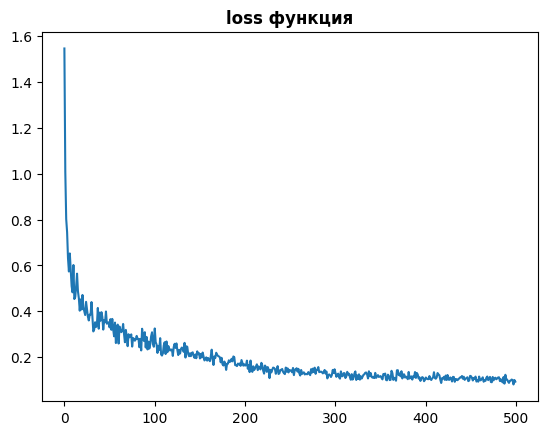

In [53]:
plt.plot(df_hist.loss)
plt.title('loss функция', fontweight='bold')
plt.show()

In [54]:
pred_neural = model.predict(X_test)
pred_neural

1/1 [==============================] - 0s 71ms/step


array([[1.176, 1.796],
       [1.034, 1.961],
       [1.179, 1.792],
       [1.173, 1.8  ],
       [1.188, 1.778],
       [1.188, 1.778],
       [0.945, 2.058],
       [1.188, 1.778],
       [1.129, 1.864],
       [1.188, 1.778],
       [1.188, 1.778]], dtype=float32)

In [55]:
print('MAE - ', np.round(np.mean(np.abs((y_test-pred_neural))), 3))

MAE -  0.072


In [56]:
mae_df.loc[len(mae_df.index)] = ['NeuralModel', np.round(np.mean(np.abs((y_test-pred_neural))), 3)]
display(mae_df.sort_values('mae'))

,model,mae
2,RandomForestRegressor,0.038
0,KNeighborsRegressor,0.040
1,CatBoostRegressor,0.040
3,NeuralModel,0.072


Нейронная сеть показывает самую плохуй оценку MAE. Тут скорее всего играют роль объективные факторы и в первую очередь маленькое количество объектов в выборке. Однако оценка MAE нейроной сети приемлемая для корректной работы, и т.к. изначала нейронная сеть стояла в приоритете над остальными моделями, сохраним модели и RandomForestRegressor и нейронной сети. 

### Сохраниение нейронной модели и модели случайного леса и их проверка после сохранения

In [57]:
#сохраняем модель нейронки
model.save("model_forecast_mlp")

INFO:tensorflow:Assets written to: model_forecast_mlp/assets


In [58]:
#получаем сохраненныу выше модель
model_load = keras.models.load_model("model_forecast_mlp")

In [59]:
#предсказание исходной модели
display(model.predict([[ 45., 141.,  10.,  80.]]))

1/1 [==============================] - 0s 31ms/step


array([[1.173, 1.8  ]], dtype=float32)

In [60]:
#предсказание сохраненной модели
display(model_load.predict([[ 45., 141.,  10.,  80.]]))

1/1 [==============================] - 0s 54ms/step


array([[1.173, 1.8  ]], dtype=float32)

In [61]:
#сохрание модели случайного леса
with open('model_rtr_pkl.pkl', 'wb') as file:
    pickle.dump(model_rtr, file)

In [62]:
#получаем сохраненную выше модель
with open('model_rtr_pkl.pkl', 'rb') as file:
    load_model_rtr = pickle.load(file)

In [63]:
#предсказание исходной модели
display(model_rtr.predict([[ 45., 141.,  10.,  80.]]))

array([[1.012, 1.843]])

In [64]:
#предсказание сохраненной модели
display(load_model_rtr.predict([[ 45., 141.,  10.,  80.]]))

array([[1.012, 1.843]])

## Вывод

Данный проект был реализованн с целю создание прототипа модели которая будет прогнозировать глубину (Depth) и ширину (Width) сварного шва в зависимости от параметров технологического процесса (IW, IF, VW, FP). 

**В ходе реализации проекта:**
- Были предобработаны данные - переименованы признаки в соотвествии со стандартами.
- Проведен разведочный анализ признаков, в т.ч. целевого на предмет наличия в них артефактов, распределения, адекватность.
- Были обнаружены аномалии и нехватка данных в выборке, по некоторым признакам, а так же мультиколериальность входных признаков. Однако было принято решение не удалять признаки, т.к. технологический процесс сварки сильно зависим от исходных параметров и удаление одного из них может сильно исказть выходной рещультат. 
- Далее признаки были подготовлены для обучения модели - поделены на тренировочные и тестовые выборки 85 на 15, и проведено масштабирование числовых признаков StandartScaler. 
- Были написаны функции для расчета оценки качества моделей и подбора гипперпараметров для выбранных моделей
- Было проведено обучение **8 моделей**, в том числе нейронной модели.

**В итоге:**

Входных данных оказалось не достаточно для проведение качественного построение взаимосвязей, особенно в нейронной моделе. Поэтому от изменнения распределения выборки, сильно зависила оценка в моделях. При random_state(13), лучшей моделью оказалась модель - `RandomForestRegressor`, однако в том числе и по вышеописанной причине, подбор гипперпараметров не оказал существенного влияение на метрике MAE. 

